### **This Notebook Detects Representative Spectra within each Surface**

This is done by building a similarity graph between each spectra, based on the Gaussian Kernel, then detecting the most representative spectra within each surface based on the PageRank centrality.

Import relevant libraries and import raw data

In [81]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import os

In [82]:
os_name = os.name

if os_name == 'nt':
    password = os.getenv('NEO4J_Password')
    neo4j_directory = os.getenv('NEO4J_Directory')
else:
    password = os.environ['NEO4J_Password']
    neo4j_directory = os.environ['NEO4J_Directory']

In [83]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_400-1800.csv")

In [84]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

#df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: normalise(x))

In [85]:
#sns.lineplot(data=df, x='WaveNumber', y='Absorbance', hue='Status', errorbar=('ci', False))

In [86]:
sample = df[df['SurID'] == '210526-3']

In [87]:
#sns.lineplot(data=sample, x='WaveNumber', y='Absorbance', hue='Status', errorbar=('ci', False))

In [88]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia
6239201,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia
6239202,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia
6239203,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia


In [89]:
pivoted_df = df.pivot(index='SpecID', columns='WaveNumber', values='Absorbance').reset_index()
pivoted_df.columns.name = None

statuses = df[['SpecID', 'Status']].drop_duplicates()

pivoted_df = pd.merge(pivoted_df, statuses, on='SpecID')
pivoted_df = pivoted_df.set_index('SpecID')

pivoted_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.3053,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1765.6628,1774.7809,1769.0302,1756.4220,1758.8690,1763.2300,1745.2285,1773.3534,1774.7166,1753.3281,...,1216.4025,1210.4993,1213.9619,1225.2153,1210.0010,1210.6858,1194.4679,1195.1451,1189.8683,Normal
201210-1-01,1966.9930,1962.4237,1954.5616,1954.3228,1963.0917,1975.0807,1979.3162,1963.4561,1968.4587,1964.0000,...,1339.4675,1382.6973,1363.7004,1360.6210,1354.0477,1353.0381,1353.9978,1361.2426,1370.2874,Normal
201210-1-02,2182.6694,2149.6565,2146.0227,2159.3459,2167.2910,2160.9861,2145.6575,2134.2004,2142.8303,2138.6309,...,1996.8234,1976.2070,1989.0183,1996.2838,1979.3507,1976.2002,1994.9839,1974.2030,1971.1880,Normal
201210-1-03,2445.0837,2430.4973,2422.7927,2434.3433,2454.9700,2462.8245,2454.7007,2467.7329,2449.5161,2421.3474,...,2010.1119,1992.3817,2022.6331,2001.8311,2010.0946,2006.4933,2017.2891,2038.1699,2000.6475,Normal
201210-1-04,2250.4536,2248.6235,2245.0984,2242.7173,2235.2803,2228.9585,2236.0095,2229.6091,2225.9231,2211.0359,...,2001.0719,2009.0385,1953.3303,1963.5698,1964.5299,1969.5634,1986.6266,1970.1484,2007.0848,Normal


In [90]:
status_df = df.groupby('SpecID')[['SurID', 'Status']].first()
# surface_and_status.to_csv("../../data/surface_and_status.csv")
status_df

,SurID,Status
SpecID,,
201210-1-00,201210-1,Normal
201210-1-01,201210-1,Normal
201210-1-02,201210-1,Normal
201210-1-03,201210-1,Normal
201210-1-04,201210-1,Normal
...,...,...
210526-3-45,210526-3,Hyperglycemia
210526-3-46,210526-3,Hyperglycemia
210526-3-47,210526-3,Hyperglycemia


>#### **Calculate an adjacency matrix using a Gaussian Kernel**

In [91]:
from scipy.spatial.distance import pdist, squareform

# Drop the 'Status' column as it is not numeric
X = pivoted_df.drop(columns=['Status'])

# Calculate pairwise Euclidean distances
distances = pdist(X.values, metric='euclidean')

# Convert the condensed distances to a square matrix form
distance_matrix = squareform(distances)

In [98]:
def gaussian_kernel(distances, sigma):
    return np.exp(-distances**2 / (2 * sigma**2))

# Sigma is the bandwidth parameter
sigma = 10000 # Adjust sigma as needed
kernel_matrix = gaussian_kernel(distance_matrix, sigma)

# Convert the kernel matrix to a DataFrame
kernel_df = pd.DataFrame(kernel_matrix, index=pivoted_df.index, columns=pivoted_df.index)

display(kernel_df.head())
kernel_df.shape

SpecID,201210-1-00,201210-1-01,201210-1-02,201210-1-03,201210-1-04,201210-1-05,201210-1-06,201210-1-07,201210-1-09,201210-1-10,...,210526-3-40,210526-3-41,210526-3-42,210526-3-43,210526-3-44,210526-3-45,210526-3-46,210526-3-47,210526-3-48,210526-3-49
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1.000000,0.711946,0.017991,0.000058,0.013190,0.002430,0.010400,0.068097,0.123862,0.453831,...,0.303273,0.459044,0.646767,0.833133,0.943973,0.943967,0.898970,0.825359,0.736301,6.180035e-01
201210-1-01,0.711946,1.000000,0.113776,0.001298,0.093070,0.026978,0.082673,0.309553,0.440659,0.839060,...,0.727671,0.859636,0.926068,0.896770,0.738691,0.600730,0.484278,0.378478,0.289538,2.044860e-01
201210-1-02,0.017991,0.113776,1.000000,0.180598,0.728509,0.531936,0.553892,0.506117,0.340344,0.143201,...,0.322824,0.219398,0.128307,0.064176,0.025953,0.013285,0.007445,0.004071,0.002167,1.030045e-03
201210-1-03,0.000058,0.001298,0.180598,1.000000,0.186858,0.287169,0.153405,0.049115,0.020039,0.002495,...,0.012757,0.005322,0.001840,0.000525,0.000114,0.000039,0.000016,0.000006,0.000002,8.408605e-07
201210-1-04,0.013190,0.093070,0.728509,0.186858,1.000000,0.815112,0.770999,0.594080,0.367481,0.132740,...,0.307763,0.201072,0.111599,0.052758,0.020127,0.009945,0.005399,0.002847,0.001484,6.845980e-04


(3045, 3045)

**Construct the node and edge import files with the required Admin Import Headers**

In [99]:
relationship_df = kernel_df.reset_index()
relationship_df = relationship_df.melt(id_vars='SpecID', var_name=':END_ID', value_name='Weight:float')
relationship_df = relationship_df.rename(columns={'SpecID': ':START_ID'})
relationship_df[':TYPE'] = 'LINK'

Drop Relationships a node has with itself, along with repeat relationships.

In [100]:
relationship_df = relationship_df[relationship_df[":START_ID"] != relationship_df[":END_ID"]]
relationship_df = relationship_df[relationship_df[":START_ID"] < relationship_df[":END_ID"]]  # Drops redundant relationships
relationship_df

,:START_ID,:END_ID,Weight:float,:TYPE
3045,201210-1-00,201210-1-01,0.711946,LINK
6090,201210-1-00,201210-1-02,0.017991,LINK
6091,201210-1-01,201210-1-02,0.113776,LINK
9135,201210-1-00,201210-1-03,0.000058,LINK
9136,201210-1-01,201210-1-03,0.001298,LINK
...,...,...,...,...
9272019,210526-3-44,210526-3-49,0.567387,LINK
9272020,210526-3-45,210526-3-49,0.720286,LINK
9272021,210526-3-46,210526-3-49,0.832085,LINK
9272022,210526-3-47,210526-3-49,0.918967,LINK


In [101]:
node_df = status_df.reset_index()
node_df.rename(columns={'SpecID':'SpecID:ID', 'Status':'Status:LABEL', 'SurID':'SurID:LABEL'}, inplace=True)
node_df

,SpecID:ID,SurID:LABEL,Status:LABEL
0,201210-1-00,201210-1,Normal
1,201210-1-01,201210-1,Normal
2,201210-1-02,201210-1,Normal
3,201210-1-03,201210-1,Normal
4,201210-1-04,201210-1,Normal
...,...,...,...
3040,210526-3-45,210526-3,Hyperglycemia
3041,210526-3-46,210526-3,Hyperglycemia
3042,210526-3-47,210526-3,Hyperglycemia
3043,210526-3-48,210526-3,Hyperglycemia


In [102]:
node_df.to_csv(f"{neo4j_directory}/import/nodes.csv", index=False)

In [103]:
relationship_df.to_csv(f"{neo4j_directory}/import/relationships.csv", index=False)

In [104]:
from neo4j import GraphDatabase
import os
import pandas as pd
import shutil
import subprocess

---

### **Neo4J Queries**

This moves the nodes and relationships files from data/current_working_graph into the DBMS import folder.

At the moment this uses local paths, but the rest should be automated.

Then run the admin import command.

In [105]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_directory}/bin'
    command = 'neo4j-admin database import full --nodes=import/nodes.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_directory}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/nodes.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
b"Neo4j version: 5.12.0\nImporting the contents of these files into /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/data/databases/neo4j:\nNodes:\n  /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/import/nodes.csv\n\nRelationships:\n  /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/import/relationships.csv\n\n\nAvailable resources:\n  Total machine memory: 13.49GiB\n  Free machine memory: 2.468GiB\n  Max heap memory : 910.5MiB\n  Max worker threads: 12\n  Configured max memory: 1.458GiB\n  High parallel IO: true\n\nCypher type normalization is enabled (disable with --normalize-types=false):\n  Property type of 'Weight' normalized from 'float' --> 'double' in /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/import/relationships.csv\n\nImport 

In [106]:
if os_name != 'nt':
    command = [
        './bin/neo4j', 'restart'
    ]

    result = subprocess.run(command, cwd=neo4j_directory, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Check if the command was successful
    if result.returncode == 0:
        print("Restart successful")
        print(result.stdout)
    else:
        print("Error during restart:")
        print(result.stderr)

Restart successful
b'Stopping Neo4j........ stopped.\nConfiguration file validation successful (with warnings).\nDirectories in use:\nhome:         /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a\nconfig:       /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/conf\nlogs:         /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/logs\nplugins:      /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/plugins\nimport:       /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/import\ndata:         /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fde3105cb8a/data\ncertificates: /home/eddie/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-e4c1e17b-4cb7-4b84-a9fb-3fd

Run and connect to the Neo4j Database

In [107]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#Password defined at the top of the notebook

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**We will calculate the centrality rank of each spectra within it's surface**

In [108]:
surfaces = status_df['SurID'].unique()
surfaces

array(['201210-1', '201210-2', '210114-1', '210114-2', '210120-1',
       '210120-2', '210121-1', '210121-2', '210211-1', '210211-2',
       '210217-1', '210217-2', '210218-1', '210224-1', '210225-1',
       '210225-2', '210303-1', '210303-2', '210304-1', '210304-2',
       '210310-1', '210310-2', '210311-1', '210311-2', '210315-1',
       '210315-2', '210318-1', '210318-2', '210324-1', '210324-2',
       '210325-1', '210325-2', '210331-1', '210401-1', '210407-1',
       '210407-2', '210414-1', '210414-2', '210414-3', '210415-1',
       '210415-2', '210419-1', '210419-2', '210421-1', '210428-1',
       '210428-2', '210428-3', '210429-1', '210504-1', '210504-2',
       '210504-3', '210505-1', '210510-1', '210510-2', '210511-1',
       '210518-1', '210519-1', '210519-2', '210519-3', '210524-1',
       '210526-1', '210526-2', '210526-3'], dtype=object)

In [109]:
pagerank_dfs = []

def project_graph(tx, surface):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      $nodeLabel,
      {
        LINK: {
          orientation: 'UNDIRECTED',
          properties: 'Weight'
        }
      }
    )
    """
    tx.run(query, nodeLabel=surface)

def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'Weight'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["score"]) for record in results]

for surface in surfaces:
    with driver.session() as session:
        session.execute_write(project_graph, surface)
        pagerank_results = session.execute_read(run_pagerank_centrality)
        pagerank_df = pd.DataFrame(pagerank_results, columns=['name', 'PageRank'])
        pagerank_df['SurfacePageRankRank'] = pagerank_df['PageRank'].rank(method='dense', ascending=False)  # Get the rank of centrality of each spectra within the surface
        pagerank_df['ReverseSurfacePageRankRank'] = pagerank_df['PageRank'].rank(method='dense')  # Get the rank of centrality of each spectra within the surface
        pagerank_dfs.append(pagerank_df)
        session.execute_write(delete_projection)


Unable to retrieve routing information
Transaction failed and will be retried in 0.9267562740995999s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 1.802234134332822s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 3.7871782940323566s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 8.885187577579002s (Unable to retrieve routing information)


In [110]:
close_driver()

In [111]:
pagerank_results = pd.concat(pagerank_dfs).rename(columns={'name':'SpecID'})
pagerank_results

,SpecID,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-33,1.124355,1.0,49.0
1,201210-1-34,1.124170,2.0,48.0
2,201210-1-32,1.111607,3.0,47.0
3,201210-1-31,1.104610,4.0,46.0
4,201210-1-01,1.096495,5.0,45.0
...,...,...,...,...
45,210526-3-23,0.711962,46.0,5.0
46,210526-3-29,0.636038,47.0,4.0
47,210526-3-24,0.635785,48.0,3.0
48,210526-3-25,0.612730,49.0,2.0


##### **Test how different Centrality Ranks affect Predictive Performance**

In [112]:
from sklearn.model_selection import cross_validate, GroupKFold
from sklearn.ensemble import ExtraTreesClassifier

In [113]:
df = df.merge(pagerank_results, on='SpecID')
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,1.064127,14.0,36.0
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,1.064127,14.0,36.0
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,1.064127,14.0,36.0
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,1.064127,14.0,36.0
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,1.064127,14.0,36.0
...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,0.945768,37.0,14.0
6239201,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,0.945768,37.0,14.0
6239202,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,0.945768,37.0,14.0
6239203,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,0.945768,37.0,14.0


In [114]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    # Include the SurID to perform GroupKFold CV
    statuses_and_surface = df[['SpecID', 'SurID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses_and_surface, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [115]:
def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = cross_validate(et, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

    # Displaying the results
    print(f"{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{et.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [116]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [117]:
wavelength_df

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1765.6628,1774.7809,1769.0302,1756.4220,1758.8690,1763.2300,1745.2285,1773.3534,1774.7166,1753.3281,...,1210.4993,1213.9619,1225.2153,1210.0010,1210.6858,1194.4679,1195.1451,1189.8683,201210-1,Normal
201210-1-01,1966.9930,1962.4237,1954.5616,1954.3228,1963.0917,1975.0807,1979.3162,1963.4561,1968.4587,1964.0000,...,1382.6973,1363.7004,1360.6210,1354.0477,1353.0381,1353.9978,1361.2426,1370.2874,201210-1,Normal
201210-1-02,2182.6694,2149.6565,2146.0227,2159.3459,2167.2910,2160.9861,2145.6575,2134.2004,2142.8303,2138.6309,...,1976.2070,1989.0183,1996.2838,1979.3507,1976.2002,1994.9839,1974.2030,1971.1880,201210-1,Normal
201210-1-03,2445.0837,2430.4973,2422.7927,2434.3433,2454.9700,2462.8245,2454.7007,2467.7329,2449.5161,2421.3474,...,1992.3817,2022.6331,2001.8311,2010.0946,2006.4933,2017.2891,2038.1699,2000.6475,201210-1,Normal
201210-1-04,2250.4536,2248.6235,2245.0984,2242.7173,2235.2803,2228.9585,2236.0095,2229.6091,2225.9231,2211.0359,...,2009.0385,1953.3303,1963.5698,1964.5299,1969.5634,1986.6266,1970.1484,2007.0848,201210-1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,1568.6929,1585.5067,1586.0128,1573.5336,1571.0054,1582.8436,1591.2191,1584.9441,1578.6371,1583.8314,...,1161.5780,1159.5455,1180.3923,1165.2845,1169.6172,1178.5277,1164.1677,1153.0132,210526-3,Hyperglycemia
210526-3-46,1517.3531,1532.3674,1526.1021,1518.3719,1520.7798,1516.9670,1531.7161,1524.9209,1526.1101,1518.5295,...,1140.6189,1117.9409,1129.4005,1127.9534,1132.3174,1127.7350,1126.1488,1145.8949,210526-3,Hyperglycemia
210526-3-47,1489.6510,1494.0872,1503.9409,1502.5331,1495.3145,1502.5530,1505.3805,1503.0844,1492.5056,1493.4546,...,1119.1401,1111.3197,1106.9562,1102.6505,1103.2274,1082.1765,1113.1180,1101.5538,210526-3,Hyperglycemia


In [118]:
evaluate_extra_trees(wavelength_df)

/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.5350 +/- 0.1277
ExtraTreesClassifier Cross-Validation Precision: 0.5399 +/- 0.1171
ExtraTreesClassifier Cross-Validation Recall: 0.5267 +/- 0.1435
ExtraTreesClassifier Cross-Validation F1-Score: 0.5077 +/- 0.1372


#### **Only keep the top k most central spectra**

In [119]:
representative_df = df[df['SurfacePageRankRank'] <= 40]
representative_df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,1.064127,14.0,36.0
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,1.064127,14.0,36.0
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,1.064127,14.0,36.0
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,1.064127,14.0,36.0
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,1.064127,14.0,36.0
...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,0.945768,37.0,14.0
6239201,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,0.945768,37.0,14.0
6239202,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,0.945768,37.0,14.0
6239203,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,0.945768,37.0,14.0


In [120]:
representative_wavelength_df = prepare_wavelength_df(representative_df, 'Absorbance')
evaluate_extra_trees(representative_wavelength_df)

/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.5514 +/- 0.1369
ExtraTreesClassifier Cross-Validation Precision: 0.5325 +/- 0.1295
ExtraTreesClassifier Cross-Validation Recall: 0.5495 +/- 0.1516
ExtraTreesClassifier Cross-Validation F1-Score: 0.5122 +/- 0.1391


#### **Alternatively, try dropping the least central spectra from each Surface**

In [121]:
representative_df = df[df['ReverseSurfacePageRankRank'] >= 10]
representative_df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,1.064127,14.0,36.0
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,1.064127,14.0,36.0
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,1.064127,14.0,36.0
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,1.064127,14.0,36.0
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,1.064127,14.0,36.0
...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,0.945768,37.0,14.0
6239201,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,0.945768,37.0,14.0
6239202,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,0.945768,37.0,14.0
6239203,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,0.945768,37.0,14.0


In [122]:
representative_wavelength_df = prepare_wavelength_df(representative_df, 'Absorbance')
evaluate_extra_trees(representative_wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.5366 +/- 0.1251
ExtraTreesClassifier Cross-Validation Precision: 0.5304 +/- 0.1368
ExtraTreesClassifier Cross-Validation Recall: 0.5263 +/- 0.1391
ExtraTreesClassifier Cross-Validation F1-Score: 0.5019 +/- 0.1383


#### **To Counter the Imbalanced Surface Size We Could Also Try A Percentage Based Cutoff**

Drop **n%** least central spectra from each surface.

In [123]:
# Calculate the nth percentile of SurfacePageRankRank for each SurID
median_ranks = df.groupby('SurID')['SurfacePageRankRank'].transform(lambda x: x.quantile(0.76))

# Keep only the rows with SurfacePageRankRank <= to its group's the chosen percentile
filtered_df = df[df['SurfacePageRankRank'] <= median_ranks]

median_ranks

0          38.00
1          38.00
2          38.00
3          38.00
4          38.00
           ...  
6239200    38.24
6239201    38.24
6239202    38.24
6239203    38.24
6239204    38.24
Name: SurfacePageRankRank, Length: 6239205, dtype: float64

In [124]:
filtered_df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,1.064127,14.0,36.0
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,1.064127,14.0,36.0
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,1.064127,14.0,36.0
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,1.064127,14.0,36.0
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,1.064127,14.0,36.0
...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,0.945768,37.0,14.0
6239201,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,0.945768,37.0,14.0
6239202,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,0.945768,37.0,14.0
6239203,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,0.945768,37.0,14.0


In [125]:
representative_wavelength_df = prepare_wavelength_df(filtered_df, 'Absorbance')
representative_wavelength_df

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1765.6628,1774.7809,1769.0302,1756.4220,1758.8690,1763.2300,1745.2285,1773.3534,1774.7166,1753.3281,...,1210.4993,1213.9619,1225.2153,1210.0010,1210.6858,1194.4679,1195.1451,1189.8683,201210-1,Normal
201210-1-01,1966.9930,1962.4237,1954.5616,1954.3228,1963.0917,1975.0807,1979.3162,1963.4561,1968.4587,1964.0000,...,1382.6973,1363.7004,1360.6210,1354.0477,1353.0381,1353.9978,1361.2426,1370.2874,201210-1,Normal
201210-1-06,2616.4783,2620.9971,2611.3452,2587.9487,2582.8250,2616.4312,2658.1443,2639.2063,2675.5098,2611.4365,...,1971.5201,1998.1563,1993.6001,2004.9166,1989.5131,1981.5663,1949.2961,1948.7775,201210-1,Normal
201210-1-07,2434.4836,2448.3164,2443.0007,2446.6353,2446.6763,2439.4451,2453.6812,2471.7271,2488.7507,2463.6619,...,1772.1354,1767.8512,1770.7791,1771.2786,1798.4928,1800.8785,1782.5182,1787.6995,201210-1,Normal
201210-1-09,2492.6379,2491.0544,2486.6711,2493.6860,2502.9224,2505.2312,2504.2173,2493.1714,2473.5293,2476.6970,...,1665.1053,1653.6478,1648.4294,1634.5895,1660.3303,1655.6666,1675.4294,1633.7750,201210-1,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,1568.6929,1585.5067,1586.0128,1573.5336,1571.0054,1582.8436,1591.2191,1584.9441,1578.6371,1583.8314,...,1161.5780,1159.5455,1180.3923,1165.2845,1169.6172,1178.5277,1164.1677,1153.0132,210526-3,Hyperglycemia
210526-3-46,1517.3531,1532.3674,1526.1021,1518.3719,1520.7798,1516.9670,1531.7161,1524.9209,1526.1101,1518.5295,...,1140.6189,1117.9409,1129.4005,1127.9534,1132.3174,1127.7350,1126.1488,1145.8949,210526-3,Hyperglycemia
210526-3-47,1489.6510,1494.0872,1503.9409,1502.5331,1495.3145,1502.5530,1505.3805,1503.0844,1492.5056,1493.4546,...,1119.1401,1111.3197,1106.9562,1102.6505,1103.2274,1082.1765,1113.1180,1101.5538,210526-3,Hyperglycemia


In [126]:
evaluate_extra_trees(representative_wavelength_df)

/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ExtraTreesClassifier Cross-Validation Accuracy: 0.5156 +/- 0.1186
ExtraTreesClassifier Cross-Validation Precision: 0.5154 +/- 0.0896
ExtraTreesClassifier Cross-Validation Recall: 0.5306 +/- 0.1449
ExtraTreesClassifier Cross-Validation F1-Score: 0.4826 +/- 0.1306


#### **Search the Best Percentage Cutoff**

In [127]:
def compare_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)

    scores = cross_validate(et, X, y, groups=groups, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'])

    # Displaying the results
    return np.mean(scores['test_accuracy'])

In [128]:
percentage = []
acurate = []

for num in np.arange(0.7, 0.95, 0.01):
    median_ranks = df.groupby('SurID')['SurfacePageRankRank'].transform(lambda x: x.quantile(num))
    filtered_df = df[df['SurfacePageRankRank'] <= median_ranks]
    filtered_representative_wavelength_df = prepare_wavelength_df(filtered_df, 'Absorbance')
    accuracy = compare_extra_trees(filtered_representative_wavelength_df)
    percentage.append(num)
    acurate.append(accuracy)

test_results = pd.DataFrame({'Percentage Cutoff':percentage, 'Accuracy':acurate})
test_results

/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eddie/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/eddie/.local/lib/python3.10/site-packages/s

,Percentage Cutoff,Accuracy
0,0.70,0.510239
1,0.71,0.529513
2,0.72,0.515820
3,0.73,0.537474
4,0.74,0.504798
5,0.75,0.539627
6,0.76,0.515633
7,0.77,0.544497
8,0.78,0.507611
9,0.79,0.540913


<Axes: xlabel='Percentage Cutoff', ylabel='Accuracy'>

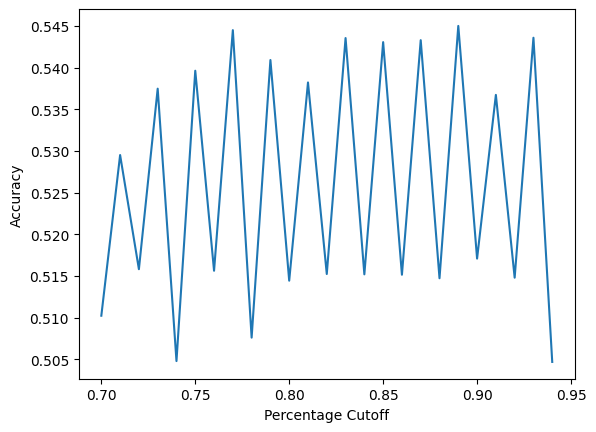

In [129]:
sns.lineplot(data=test_results, x='Percentage Cutoff', y='Accuracy')

In [134]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,PageRank,SurfacePageRankRank,ReverseSurfacePageRankRank
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal,1.064127,14.0,36.0
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal,1.064127,14.0,36.0
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal,1.064127,14.0,36.0
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal,1.064127,14.0,36.0
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal,1.064127,14.0,36.0
...,...,...,...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,1617.3926,210526-3,Hyperglycemia,0.945768,37.0,14.0
6239201,210526-3-09,2338,1797.72200,1633.0911,210526-3,Hyperglycemia,0.945768,37.0,14.0
6239202,210526-3-09,2339,1798.40550,1633.3076,210526-3,Hyperglycemia,0.945768,37.0,14.0
6239203,210526-3-09,2340,1799.08890,1641.8665,210526-3,Hyperglycemia,0.945768,37.0,14.0


In [136]:
df.groupby('SurID')['PageRank'].describe()

,count,mean,std,min,25%,50%,75%,max
SurID,,,,,,,,
201210-1,100401.0,0.96124,0.158088,0.312918,0.897695,1.024794,1.069516,1.124355
201210-2,102450.0,0.96124,0.195850,0.384995,0.943968,0.961780,1.051564,1.299212
210114-1,102450.0,0.96124,0.152457,0.161332,0.991381,1.005018,1.014932,1.018269
210114-2,102450.0,0.96124,0.252683,0.196016,1.013518,1.043755,1.058198,1.572297
210120-1,102450.0,0.96124,0.198896,0.199835,0.906806,1.026267,1.097397,1.142007
...,...,...,...,...,...,...,...,...
210519-3,102450.0,0.96124,0.149986,0.314386,0.948618,0.986149,1.045272,1.089632
210524-1,30735.0,0.96124,0.155334,0.576327,0.879098,0.981084,1.116856,1.137114
210526-1,102450.0,0.96124,0.199419,0.425165,0.838898,1.031597,1.126026,1.177096
